<a href="https://colab.research.google.com/github/joaochenriques/GeneratorCalib/blob/main/FilterData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pylab import plot, legend, show, figure, subplot, \
                  xlabel, ylabel, grid, semilogy, pi,\
                  title, average, unwrap, angle, xlim
from numpy import concatenate, zeros, ones, array, polyval, arange, log10,\
                  dot, polyfit, poly1d, linspace, polyval

from scipy.signal import freqz
import numpy as np

In [2]:
# If running python on Windows operating system, copy the file:
# https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py
# to the working folder before running the notebook
import matplotlib.pyplot as mpl

import pathlib
if not pathlib.Path("mpl_utils.py").exists():
  !curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py 

import mpl_utils as mut
mut.config_plots()

%config InlineBackend.figure_formats = ['svg']
mpl.rcParams["figure.figsize"] = (6,4.5)

In [ ]:
def filters_sym_6th( pnts_seq ):

  b_lst = []
  for Npts in pnts_seq:
    b = zeros( Npts )

    float_Npts = float( Npts )
    hpts = Npts / 2

    if Npts % 2 == 0:
      print( ' Number of points should be an odd ', Npts )
      exit(1)

    CONST6_0 = (   1225.E0*float_Npts**6 -  57575.E0*float_Npts**4 +  \
                 605395.E0*float_Npts**2 - 952245.E0 ) / 64.E0
    CONST6_2 = ( -11025.E0*float_Npts**4 + 330750.E0*float_Npts**2
               -1507485.E0 ) / 16.E0
    CONST6_4 = (  24255.E0*float_Npts**2 - 347655.E0 ) / 4.E0
    CONST6_6 = -15015.E0
    Denomi_6 =  4.E0 * float_Npts * ( float_Npts**6 - 56.E0*float_Npts**4
            + 784.E0*float_Npts**2 - 2304.E0 )

    mid_Coef = array( [ CONST6_0 / Denomi_6 ] )
    pl = array( [CONST6_6, 0.0, CONST6_4, 0.0, CONST6_2, 0.0, CONST6_0] )

    float_I = arange( 1.0, hpts + 0.1, 1.0 )

    Coefs = polyval( pl, float_I ) / Denomi_6

    lst = concatenate( ( Coefs[::-1], mid_Coef, Coefs ) )
    b_lst.append( lst )
    
  return b_lst

In [74]:
def filters_plot( bhigh, f_sample, numfig, name1, name2, clr='r' ):

  filter_name = []
  first = True
  figure( numfig )

  ax1 = subplot(111)
  ylabel( 'Gain [-]' )
  xlabel( 'Frequency [Hz]' )
  grid()

  freqs = linspace( 0.0, 1.0 / 10.0, 62500 )
  nplot = len( freqs )

  wf = None
  hf = ones( nplot )

  for b in bhigh:
    n = b.size
    filter_name.append( n )
    a = zeros(n)
    a[ n // 2 ] = 1.0
    w, h = freqz( b, a, freqs )
    hf *= abs(h)

    ah  = abs(h)

    if first:
      wf  = w.copy()
      wf *= f_sample / ( 2.0 * pi )

    ax1.semilogy( wf, ah, label=f"{name2} filter, $n={n}$", lw=1 )
    first = False

  if len(bhigh) > 1:
    ax1.semilogy( wf, hf, 'k-', lw=2, label = 'cascade filter' )
  
  ax1.legend(loc = 'lower left', fontsize=11)

#   title( f'{name1} filter $(f_\mathrm{{s}} = {f_sample/1000.0:1}\,$kHz)' )

  return ax1, wf, hf

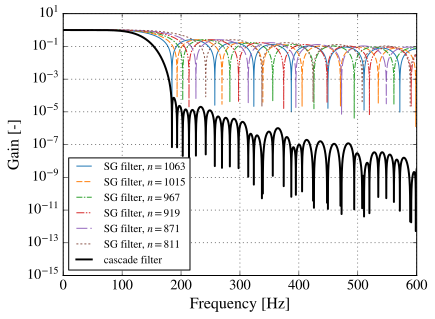

In [75]:
f_sample = 62500.0
high_filter_seq = array( [1063,  1015,   967,   919,   871,   811] )

high_b = filters_sym_6th( high_filter_seq )
ax1, wf, hf = filters_plot( high_b, f_sample, 30, 'Cascade', 'SG', 'k' )
ax1.set_xlim( (0,600) )
wf[3143], hf[3143]
mpl.savefig('Casc_Filter.pdf', bbox_inches='tight')

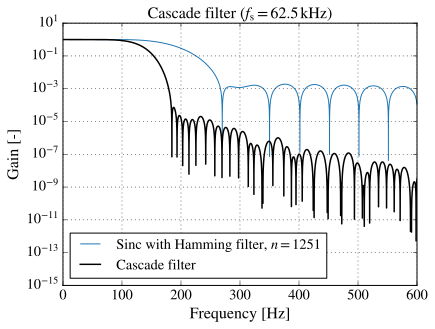

In [72]:
M = 1251
m  = int( ( M-1 ) / 2 )
k =  np.linspace( -m, m, 2*m+1 )
fc = 180
sigma = 0.35
h = 2 * fc / f_sample * np.sinc( 2 * fc / f_sample * k ) * np.hamming(M)
# h = 2 * fc / f_sample * np.sinc( 2 * fc / f_sample * k ) * np.exp( -0.5*(k/f_sample)**2/sigma**2 ) 
h /= np.sum(h)
ax1, wf2, hf2 = filters_plot( [h], f_sample, 30, 'Cascade', 'Sinc with Hamming', 'k' )
ax1.semilogy( wf, hf, 'k-', lw=1.5, label = 'Cascade filter' );
ax1.legend(loc='lower left')
ax1.set_xlim(0,600)
wf2[3143], hf2[3143]
mpl.savefig('Casc_Sinc_filters.pdf', bbox_inches='tight')

(50.02319898496646, 0.9988024667482197)